# Kernel integration

In DFT, the exchange–correlation kernel integrations are performed numerically

$$
E_\mathrm{xc}[n(\mathbf{r})] = \int
n(\mathbf{r}) \,
\varepsilon_\mathrm{xc}(n, \nabla n, \nabla^2 n) \, \mathrm{d}^3\mathbf{r} 
\approx
\sum_{i=1}^P
w_i \,
n(\mathbf{r}_i) \,
\varepsilon_\mathrm{xc}(n, \nabla n, \nabla^2 n)
\,\Big|_{\mathbf{r} = \mathbf{r}_i}
$$

In VeloxChem, the set of grid points and the associated grid-point weights, $w_i$ are constructed using modified versions of the Log3-quadrature {cite}`Treutler1995` and SSF-partitioning schemes {cite}`Stratmann1996`. In practical work, the number of grid points, $P$, amounts to in the order of $10^6$.

Integration of the density itself results in the number of electrons in the system. Let us explore this simple case to assess the accuracy in the numerical integration scheme. We will use the electron density of the water molecule in our example calculations.

In [1]:
import veloxchem as vlx
import matplotlib.pyplot as plt
import numpy as np

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 8.


In [2]:
# define a molecular system
h2o_xyz = """3
water
O    0.000000000000        0.000000000000        0.000000000000
H    0.000000000000        0.740848095288        0.582094932012
H    0.000000000000       -0.740848095288        0.582094932012
"""
molecule = vlx.Molecule.from_xyz_string(h2o_xyz)

# determine the method
scf_drv = vlx.ScfRestrictedDriver()
method_settings = {'xcfun': 'b3lyp', 'grid_level': 4}
scf_drv.update_settings({}, method_settings)

## Molecular grid points

In the Python layer, VeloxChem provides access to the creation of molecular grids with the `GridDriver` class. 

In [3]:
grid_drv = vlx.veloxchemlib.GridDriver()

grid_drv.set_level(4) # default level in VeloxChem
mol_grid = grid_drv.generate(molecule)

# grid point coordinates
x = mol_grid.x_to_numpy()
y = mol_grid.y_to_numpy()
z = mol_grid.z_to_numpy()

P = mol_grid.number_of_points()
print('Number of grid points:', P)

Number of grid points: 35884


Visualize all grid points outside the sphere of radius 5.0 $a_0$.

In [4]:
grid_xyz = "\nGrid points\n"

r = np.sqrt(x**2 + y**2 + z**2)

au2ang = 0.52911721

i=0
for p in range(P):
    if r[p] > 5.0:
        grid_xyz += f"He {x[p] * au2ang : 16.8f} {y[p] * au2ang : 16.8f} {z[p] * au2ang : 16.8f}\n"
        i+=1
        
grid_xyz = str(i) + grid_xyz

print('Number of grid point outside sphere:', i)
print('Number of grid point inside sphere:', P - i)

Number of grid point outside sphere: 5002
Number of grid point inside sphere: 30882


Not surprisingly, the grid point density is much larger inside the van der Waals volume of the molecule where the electron density is large.

Let us visualize all grid points outside the sphere of radius 5.0 $a_0$.

In [5]:
import py3Dmol as p3d

v = p3d.view(width=400, height=400)

v.addModel(h2o_xyz, 'xyz')
v.setStyle({'stick': {}})
v.addSurface(p3d.VDW,{'opacity': 0.7, 'color': 'green'})

v.addModel(grid_xyz, 'xyz')
v.setStyle({'elem': 'He'}, {'sphere': {'radius': 0.05, 'color': 'red', 'opacity': 0.5}})

v.zoomTo()

v.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Another important view of the grid points is from the perspective of their atomic radial density. It can be clearly seen that the grid density is much larger in the regions of the density maxima of the atomic shells.

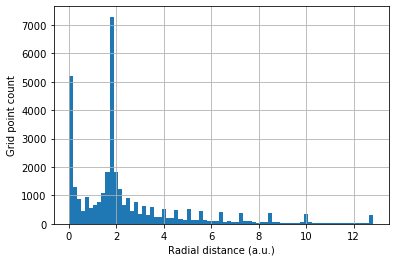

In [6]:
count, rad_dist, patches = plt.hist(r, bins = 75)

plt.grid(True)
plt.xlabel('Radial distance (a.u.)')
plt.ylabel('Grid point count')

plt.show()

## Density on grid points

Access to the electron density at the grid points is provided with the `DensityGridDriver` class. In a first example, we will study the total ground-state electron density and perform the integration with molecular grids of vaying size and thereby quality. The quality of the grid is determined by the grid level and VeloxChem presently offers grid levels ranging from one to six and for water that amounts to a number of grid points ranging from 4,400 to 1,107,900.

In [7]:
basis = vlx.MolecularBasis.read(molecule, "def2-svpd")
scf_drv.compute(molecule, basis) # perform an SCF optimization

den_drv = vlx.veloxchemlib.DensityGridDriver()

den_mats = scf_drv.scf_tensors['D'] # tuple of (alpha, beta) spin densities
den_array_format = np.array([den_mats[0], den_mats[1]])
den_cpp_format = vlx.veloxchemlib.AODensityMatrix(den_array_format, vlx.veloxchemlib.denmat.rest)

xctype = 'LDA' # generate densities but no gradients of densities
    
n_grid_points = []
n_elec = []

for grid_level in range(1,7):

    grid_drv.set_level(grid_level) # available grid levels are between 1-6

    # generate grid points and weights for molecule
    mol_grid = grid_drv.generate(molecule)
    weights = mol_grid.w_to_numpy()
    n_grid_points.append(mol_grid.number_of_points())

    # generate density on grid
    den_grid = den_drv.generate(den_cpp_format, molecule, basis, mol_grid, xctype)
    den_alpha = den_grid.density_aa_to_numpy(0)
    den_beta  = den_grid.density_bb_to_numpy(0)

    n_elec.append(np.dot(weights, den_alpha) + np.dot(weights, den_beta))

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Kohn-Sham                                            
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

In [8]:
print('Number of grid points:', n_grid_points)

Number of grid points: [4404, 10536, 20678, 35884, 63844, 1107906]


As measure of accuracy in the numerical integration, we will use the absolute value of the difference between the integer number of electron (ten for water) and the value of the integral with varing grid levels. This error measure is illustrated below in the plot.

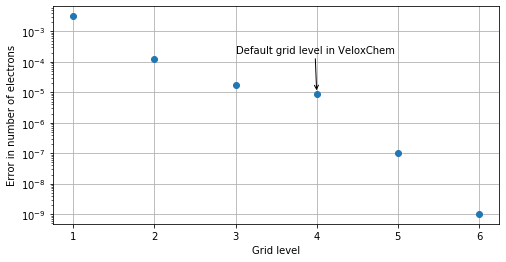

In [9]:
fig = plt.figure(figsize = (8,4))

error = abs(np.array(n_elec) - 10)

plt.plot(range(1,7), error, 'o')

plt.annotate('Default grid level in VeloxChem', (4, 1e-5), xytext = (3, 2e-4), arrowprops = {'arrowstyle': '->'})

plt.grid()
plt.yscale('log')

plt.xlabel('Grid level')
plt.ylabel('Error in number of electrons')

plt.show()

It is seen that the error in the numerical integration ranges from $10^{-2}$ to $10^{-9}$ and the error at the default grid level amounts to $10^{-5}$ electrons. These results are rather insensitive to the choice of basis set as the location of radial density maxima for the *occupied* orbitals do not change much with the choice of basis set, and the numerical grids are optimized to cover well these spatial regoins.

It is less clear, however, how well the grid points cover the important spatial regions of the unoccupied (virtual) orbitals that become important in the calculation of excited states and therefore also in simulations of spectroscopies. To analyze this aspect further, we lock the grid level to four and instead perform numerical integrations of the densities of occupied and unoccupied orbitals. The reference integer number of electrons is in this case equal to two.

We will compare the results for two standard basis sets that are frequently used in DFT spectroscopy calculations namely `def2-svpd` and `aug-cc-pvdz`.

In [10]:
grid_drv.set_level(4) # default level is 4 in VeloxChem
# generate grid points and weights for molecule
mol_grid = grid_drv.generate(molecule)
weights = mol_grid.w_to_numpy()
n_grid_points.append(mol_grid.number_of_points())

xctype = 'LDA' # generate densities but no gradients of densities

n_elec = {}
norb = {}

basis_sets = ['def2-svpd', 'aug-cc-pvdz']
for basis_set in basis_sets:
    
    basis = vlx.MolecularBasis.read(molecule, basis_set)
    scf_drv.compute(molecule, basis)    # perform an SCF optimization

    C = scf_drv.scf_tensors['C']        # MO coefficients
    norb[basis_set] = C.shape[1]        # number of molecular orbitals

    n_elec[basis_set] = []
    
    for mo in range(norb[basis_set]):
        D = np.einsum('a, b -> ab', C[:,mo], C[:,mo]) # orbital density
        den_array_format = np.array([D, D])
        den_cpp_format = vlx.veloxchemlib.AODensityMatrix(den_array_format, vlx.veloxchemlib.denmat.rest)

        # generate density on grid
        den_grid = den_drv.generate(den_cpp_format, molecule, basis, mol_grid, xctype)
        den_alpha = den_grid.density_aa_to_numpy(0)
        den_beta  = den_grid.density_bb_to_numpy(0)

        n_elec[basis_set].append(np.dot(weights, den_alpha) + np.dot(weights, den_beta))

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Kohn-Sham                                            
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

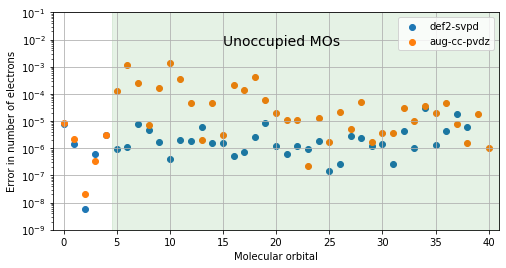

In [11]:
fig = plt.figure(figsize = (8,4))
ax = plt.axes(xlim = (-1, 41), ylim = (1e-9, 1e-1))

plt.grid(True)
plt.yscale('log')

for basis_set in basis_sets:
    error = abs(np.array(n_elec[basis_set]) - 2)
    plt.scatter(range(norb[basis_set]), error, label = basis_set)

plt.legend()

ax.fill_between([4.6, 41], 0, 1, color='green', alpha=0.1, transform = ax.get_xaxis_transform())
ax.text(15, 0.85, 'Unoccupied MOs', size = 14, transform = ax.get_xaxis_transform())

plt.xlabel('Molecular orbital')
plt.ylabel('Error in number of electrons')

plt.show()

The lowest five orbitals are occupied and for those we note that the largest error is seen in the numerical integration of the core 1s-orbital of oxygen and it is noted that the errors are very much alike for the two basis sets. For the unoccupied orbitals, on the other hand, the two basis sets give very different results. While the errors obtained with use of the `def2-svpd` basis set remain small for all virtual orbitals , they occationally reach above $10^{-3}$ electrons for the `aug-cc-pvdz` basis set. Somewhat alarmingly, it is the lower virtual orbitals that suffer the largest errors at the same time as these are the most important ones in spectrum simulations.